In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.BinnedTestSetSplitter import BinnedTestSetSplitter
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from binnedtestsetsplitter.binnedtestsetsplitter import BinnedTestSetSplitter
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [5]:
if is_kaggle:
    data_path = '/kaggle/input/har70'
else:
    data_path = os.path.abspath(os.path.join('..', 'data'))

In [6]:
if not is_kaggle:
    # Download data
    downloader = DataDownloader()
    downloader.download_data('har70plus', data_path)

Dataset already downloaded


In [7]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,record_num
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,0
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,1
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,2
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,3
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,4
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,2259592
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,2259593
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,2259594
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,2259595


In [8]:
test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

In [9]:
from sklearn.model_selection import train_test_split

dataset = collector.get_collected_data()

# The features are in the 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z' columns
features = dataset[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp']]
labels = dataset['label']

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_split, random_state=42, stratify=labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42, stratify=y_train)

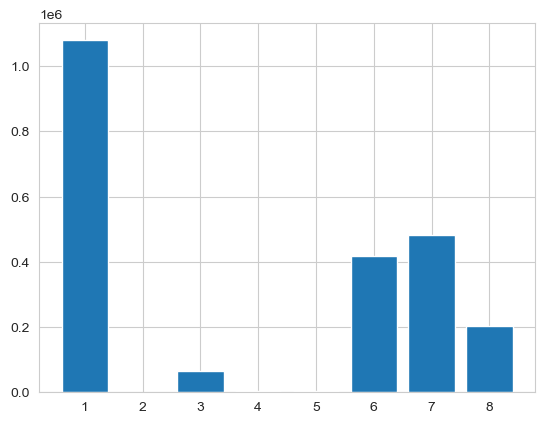

In [10]:
# Plot the distribution of the labels
label_counts = collections.Counter(labels)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

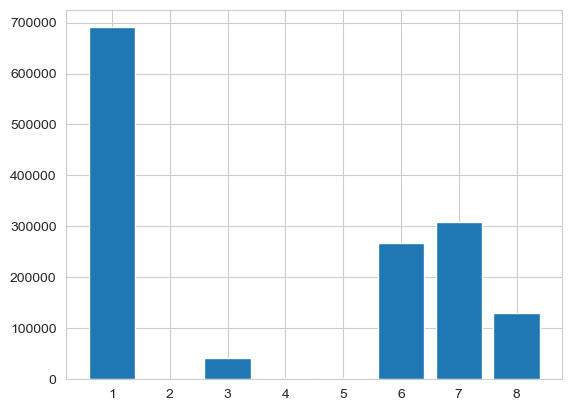

In [11]:
# Plot the distribution of the labels in the training set
label_counts = collections.Counter(y_train)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

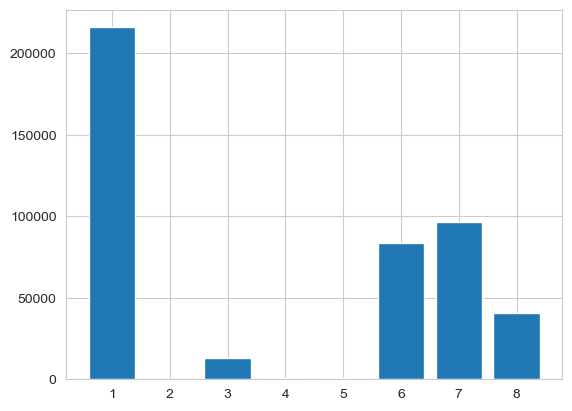

In [12]:
# Plot the distribution of the labels in the test set
label_counts = collections.Counter(y_test)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

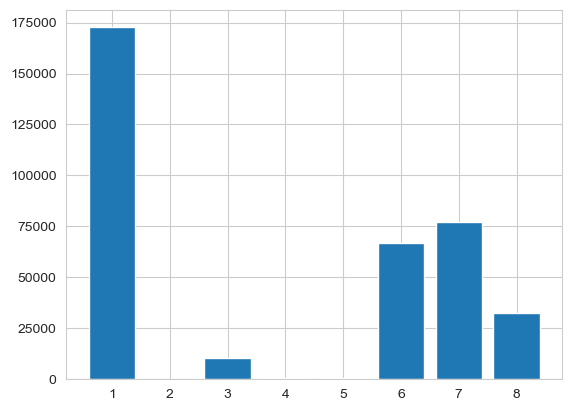

In [13]:
# Plot the distribution of the labels in the validation set
label_counts = collections.Counter(y_val)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

In [14]:
# Get the number of each label in each set
train_label_counts = collections.Counter(y_train)
test_label_counts = collections.Counter(y_test)
val_label_counts = collections.Counter(y_val)

print(f"Train label counts: {train_label_counts}")
print(f"Test label counts: {test_label_counts}")
print(f"Validation label counts: {val_label_counts}")

Train label counts: Counter({1: 690759, 7: 309409, 6: 267555, 8: 130037, 3: 42277, 5: 3186, 4: 2918})
Test label counts: Counter({1: 215863, 7: 96690, 6: 83611, 8: 40636, 3: 13212, 5: 996, 4: 912})
Validation label counts: Counter({1: 172690, 7: 77353, 6: 66889, 8: 32509, 3: 10569, 5: 796, 4: 730})


In [15]:
# Calculate a ratio of the number of each label in each set
train_label_ratios = {label: count / len(y_train) for label, count in train_label_counts.items()}
test_label_ratios = {label: count / len(y_test) for label, count in test_label_counts.items()}
val_label_ratios = {label: count / len(y_val) for label, count in val_label_counts.items()}

# Sort the ratios by label
train_label_ratios = dict(sorted(train_label_ratios.items()))
test_label_ratios = dict(sorted(test_label_ratios.items()))
val_label_ratios = dict(sorted(val_label_ratios.items()))

print(f"Train label ratios: {train_label_ratios}")
print(f"Test label ratios: {test_label_ratios}")
print(f"Validation label ratios: {val_label_ratios}")

Train label ratios: {1: 0.4776567430146853, 3: 0.029234355432838154, 4: 0.002017783881378095, 5: 0.0022031046765149456, 6: 0.18501307963746275, 7: 0.21395493247200653, 8: 0.08992000088511425}
Test label ratios: {1: 0.47765755000885113, 3: 0.029235262878385553, 4: 0.00201805629314923, 5: 0.0022039298990971855, 6: 0.1850128341299345, 7: 0.2139537971322358, 8: 0.0899185696583466}
Validation label ratios: {1: 0.47765644361833953, 3: 0.029233603292618163, 4: 0.002019162683660825, 5: 0.002201717118073995, 6: 0.1850133873251903, 7: 0.21395656310851477, 8: 0.0899191228536024}


In [16]:
# Lets check the order of the columns in the features dataframe
features.columns

Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z',
       'record_num', 'timestamp'],
      dtype='object')

In [37]:
splitter = BinnedTestSetSplitter(test_size=test_split, val_size=validation_split, seed=42)

splitter.generate_splits(features, labels, chunk_size=256)

x_train, y_train, x_val, y_val, x_test, y_test = splitter.get_splits()

Chunks shape:  (8827, 256, 8)
Data shape:  (8827, 2048) (8827, 256)


In [38]:
# The data has been converted to numpy arrays, so we need to convert it back to dataframes
x_train = pd.DataFrame(x_train, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])
x_val = pd.DataFrame(x_val, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])
x_test = pd.DataFrame(x_test, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])

y_train = pd.Series(y_train, name='label')
y_val = pd.Series(y_val, name='label')
y_test = pd.Series(y_test, name='label')

In [39]:
# Grab the first 5 rows of the training set
x_train.head()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,record_num,timestamp
0,-0.630859,-0.201416,0.763184,-0.012207,0.080811,-0.99707,2126336,2021-06-11 10:27:32.179
1,-0.630859,-0.187988,0.760742,-0.012207,0.078613,-0.99707,2126337,2021-06-11 10:27:32.199
2,-0.630859,-0.190186,0.76123,-0.012207,0.078613,-0.99707,2126338,2021-06-11 10:27:32.219
3,-0.630859,-0.190186,0.758301,-0.012207,0.078613,-0.99707,2126339,2021-06-11 10:27:32.238
4,-0.630859,-0.190186,0.745117,-0.012207,0.078613,-0.99707,2126340,2021-06-11 10:27:32.258


In [40]:
x_train.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,record_num,timestamp
count,1445888.0,1445888.0,1.445888e+06,1.445888e+06,1445888.0,1.445888e+06,1445888,1445888
unique,8941.0,6440.0,8.728000e+03,1.768200e+04,15134.0,1.647900e+04,1445773,1445773
top,-1.0,0.0,8.906250e-01,-9.687500e-01,0.0,-1.093750e+00,2259596,2021-06-11 11:13:14.178
freq,35930.0,19031.0,1.304300e+04,3.872700e+04,14239.0,3.665600e+04,116,116


In [41]:
# Get the number of each label in each set
train_label_counts = collections.Counter(y_train)
test_label_counts = collections.Counter(y_test)
val_label_counts = collections.Counter(y_val)

print(f"Train label counts: {train_label_counts}")
print(f"Test label counts: {test_label_counts}")
print(f"Validation label counts: {val_label_counts}")

Train label counts: Counter({1: 698232, 7: 300374, 6: 273143, 8: 126497, 3: 41580, 5: 3134, 4: 2928})
Test label counts: Counter({1: 213687, 7: 98392, 6: 80076, 8: 44374, 3: 13154, 5: 1386, 4: 1027})
Validation label counts: Counter({1: 167508, 7: 84686, 6: 64836, 8: 32311, 3: 11324, 4: 605, 5: 458})


In [42]:
# Calculate a ratio of the number of each label in each set
train_label_ratios = {label: count / len(y_train) for label, count in train_label_counts.items()}
test_label_ratios = {label: count / len(y_test) for label, count in test_label_counts.items()}
val_label_ratios = {label: count / len(y_val) for label, count in val_label_counts.items()}

# Sort the ratios by label
train_label_ratios = dict(sorted(train_label_ratios.items()))
test_label_ratios = dict(sorted(test_label_ratios.items()))
val_label_ratios = dict(sorted(val_label_ratios.items()))

print(f"Train label ratios: {train_label_ratios}")
print(f"Test label ratios: {test_label_ratios}")
print(f"Validation label ratios: {val_label_ratios}")

Train label ratios: {1: 0.4829087730169972, 3: 0.028757414128895185, 4: 0.002025053116147309, 5: 0.0021675261154390935, 6: 0.1889102060463881, 7: 0.20774361499645894, 8: 0.08748741257967423}
Test label ratios: {1: 0.4726584619195923, 3: 0.02909559031710079, 4: 0.0022716414212910533, 5: 0.0030657205549263875, 6: 0.17712167327293318, 7: 0.2176351925254813, 8: 0.09815171998867497}
Validation label ratios: {1: 0.46307722929936307, 3: 0.03130529016277424, 4: 0.001672527423920736, 5: 0.001266144727530078, 6: 0.17923964968152867, 7: 0.23411513623496108, 8: 0.08932402246992215}


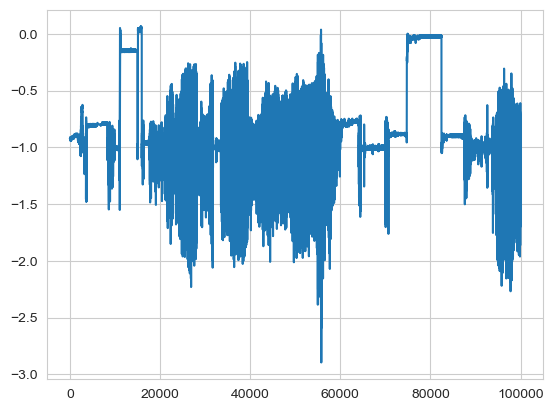

In [43]:
# We may need to re-sort the dataframes to ensure that the temporal order is preserved. We can do this by sorting by the 'record_num' column
x_train = x_train.sort_values('record_num')
y_train = y_train.loc[x_train.index]

x_val = x_val.sort_values('record_num')
y_val = y_val.loc[x_val.index]

x_test = x_test.sort_values('record_num')
y_test = y_test.loc[x_test.index]

#Plot the training set in order to check that the temporal order is preserved
# Max of 100000 samples to avoid memory issues
# Only plot back_x too
plt.plot(range(100000), x_train['back_x'][:100000])

In [44]:
# The records are out of order, we need to make sure that they are ordered by record_num
x_train = x_train.sort_values('record_num')

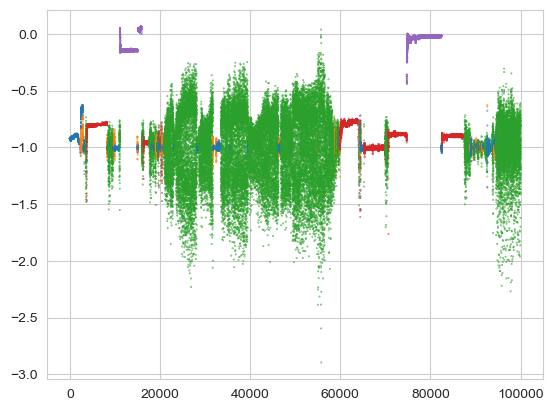

In [45]:
# Let's plot the training set, but colour each label differently
# Max of 100000 samples to avoid memory issues

# Get the unique labels
unique_labels = y_train.unique()

# Create a dictionary to map each label to a colour
label_colour_map = {label: f"C{i}" for i, label in enumerate(unique_labels)}

# Create a list of colours for each label
label_colours = [label_colour_map[label] for label in y_train]

plt.scatter(range(100000), x_train['back_x'][:100000], c=label_colours[:100000], s=0.1)


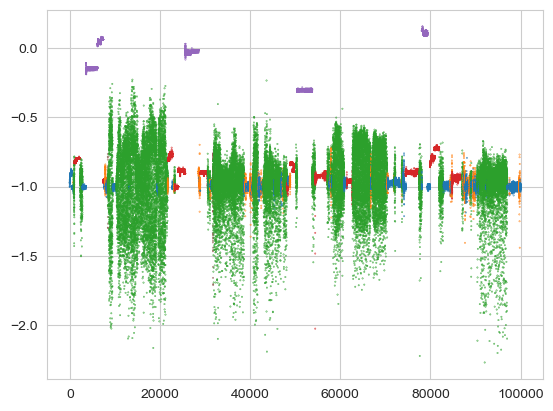

In [46]:
# Let's plot the test set, but colour each label differently
# Max of 100000 samples to avoid memory issues

# Get the unique labels
unique_labels = y_test.unique()

# Create a dictionary to map each label to a colour
label_colour_map = {label: f"C{i}" for i, label in enumerate(unique_labels)}

# Create a list of colours for each label
label_colours = [label_colour_map[label] for label in y_test]

plt.scatter(range(100000), x_test['back_x'][:100000], c=label_colours[:100000], s=0.1)